In [1]:
import pandas as pd
import numpy as np

# Downloading the data

The next block is used to tackle a SSLCertVerificationError.

In [2]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context


In [3]:
from sklearn.datasets import fetch_openml

/home/shivam/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [4]:
mnist=fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
X,y=mnist["data"],mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit=X[0]
some_digit_image=some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()
print(y[0])

<Figure size 640x480 with 1 Axes>

5


The labels are strings, hence casting them to integer

In [7]:
y=y.astype(np.uint8)

In [8]:
X_train, X_test, y_train, y_test=X[:60000],X[60000:],y[:60000],y[60000:]

Using binary classifer here. It can only predict 1 or 0. Hence writing the code for it to detect 5 only.

In [9]:
y_train_5=(y_train==5)
y_test_5=(y_test==5)

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf=SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict([some_digit])


array([ True])

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds=StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train,y_train_5):
    clone_clf=clone(sgd_clf)
    X_train_folds=X_train[train_index]
    y_train_folds=y_train_5[train_index]
    X_test_fold=X_train[test_index]
    y_test_fold=y_train_5[test_index]
    
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred=clone_clf.predict(X_test_fold)
    n_correct=sum(y_pred==y_test_fold)
    print(n_correct/len(y_pred))

/home/shivam/snap/jupyter/common/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train,y_train_5,cv=3,scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

The accuracy is high only because only 10% of the data is 5 and hence whenever the model predicts an image to not be a 5, its correct 90% of the time. This can be proved using the next block. This model predicts all the images as 'not-5'.

In [14]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)
    

In [15]:
never_5_clf=Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In classification problems the accuracy is not trustable. It is suspectible to skewed data(some classes more frequent than the others)

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred=cross_val_predict(sgd_clf, X_train,y_train_5,cv=3)

In [17]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

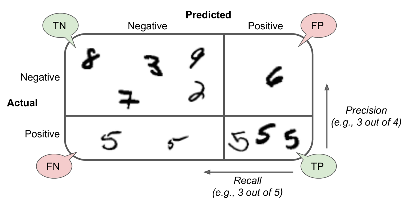

Above is the confusion matrix

In [19]:
from sklearn.metrics import precision_score,recall_score

precision_score(y_train_5,y_train_pred)

0.8370879772350012

The model gives correct outputs 83.70% of the time

In [20]:
recall_score(y_train_5,y_train_pred)

0.6511713705958311

The model detects 65.11% of 5s correctly

We combine precision and recall to calculate F1 score. Its the harmonic mean between precision and recall. Harmonic because it doesn't treat both values similarly but gives more weightage to the smaller one. Hence both the values needs to be high in order to F1 be high.

In [21]:
from sklearn.metrics import f1_score

f1_score(y_train_5,y_train_pred)

0.7325171197343846

Rejecting good result---> Low Recall
Accepting good result---> High Precision

Both precision and recall can't remain high. This is called precision/recall trade-off

The predict() method doesn't allow us to set a threshold whereas decision_finction() does allow us to do that. The threshold of predict() is 0.

In [22]:
y_scores=sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [23]:
threshold=8000
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred

array([False])

Increasing the thershold decreases the recall.

We will use cross_val_predict() inorder to get a apt threshold

In [24]:
y_scores=cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")

In [25]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds= precision_recall_curve(y_train_5,y_scores)

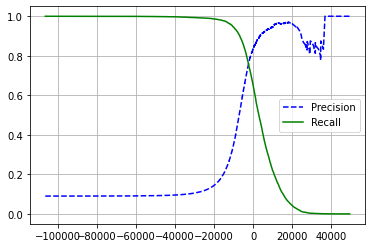

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1],"b--",label="Precision")
    plt.plot(thresholds,recalls[:-1],"g-",label="Recall")
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.legend()
plt.grid()
plt.show()

In [27]:
threshold_90_precision=thresholds[np.argmax(precisions>=0.90)]
threshold_90_precision

3370.0194991439557

In [28]:
y_train_pred_90=(y_scores>=threshold_90_precision)

In [29]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [30]:
recall_score(y_train_5,y_train_pred_90)

0.4799852425751706

## The ROC curve

Stands for Reciever operating characteristic

True Positive Rates(TPR) == Recall == sensitivity

False Positive Rates(FPR) == 1-True Negative Rate(TNR) == 1-specifity

The ROC curve plots sensitivity versus 1-specificity

In [31]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds=roc_curve(y_train_5, y_scores)

/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
No handles with labels found to put in legend.


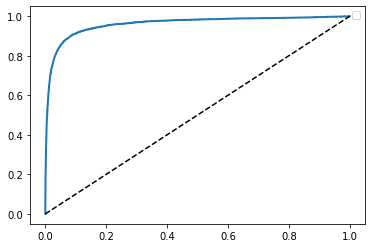

In [32]:
def plot_roc_curves(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axes()
    plt.legend()
plot_roc_curves(fpr,tpr)
plt.show()

A classifier is perfect if it has the area under the curve as 1.

In [33]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.9604938554008616

Use PR curve whenever the positive cases are rare. In the other cases use ROC.

## RandomForestClassifier

In [34]:
from sklearn.ensemble import RandomForestClassifier

forest_clf=RandomForestClassifier(random_state=42)
y_probas_forest=cross_val_predict(forest_clf, X_train, y_train_5,cv=3, method="predict_proba")

In [35]:
y_scores_forest=y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest= roc_curve(y_train_5, y_scores_forest)

/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


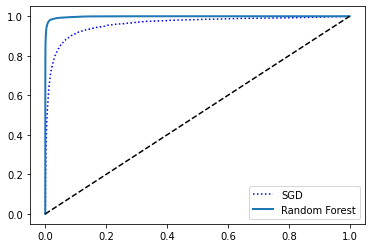

In [36]:
plt.plot(fpr,tpr,"b:",label="SGD")
plot_roc_curves(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [37]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [38]:
from sklearn.svm import SVC

svm_clf=SVC()
svm_clf.fit(X_train,y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [39]:
some_digit_scores=svm_clf.decision_function([some_digit])

In [40]:
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [41]:
np.argmax(some_digit_scores)

5

In [42]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [43]:
svm_clf.classes_[5]

5

In [44]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf=OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [45]:
len(ovr_clf.estimators_)

10

In [46]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [47]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [48]:
cross_val_score(sgd_clf, X_train, y_train,cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [50]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf,X_train_scaled, y_train,cv=3,scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [52]:
y_train_pred=cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)
conf_mx=confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

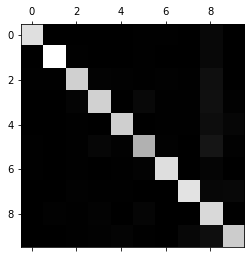

In [53]:
plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.show()

In [56]:
row_sums=conf_mx.sum(axis=1,keepdims=True)
norm_conf_mx=conf_mx/row_sums

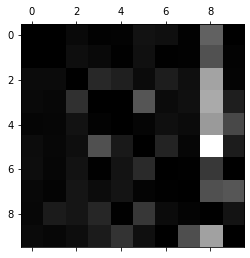

In [57]:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)
plt.show()

In [58]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large=(y_train>=7)
y_train_odd=(y_train&2==1)
y_multilabel=np.c_[y_train_large, y_train_odd]
knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [59]:
knn_clf.predict([some_digit])

array([[False, False]])

In [60]:
y_train_knn_pred=cross_val_predict(knn_clf,X_train,y_multilabel,cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

/home/shivam/snap/jupyter/common/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


0.4854228620660905